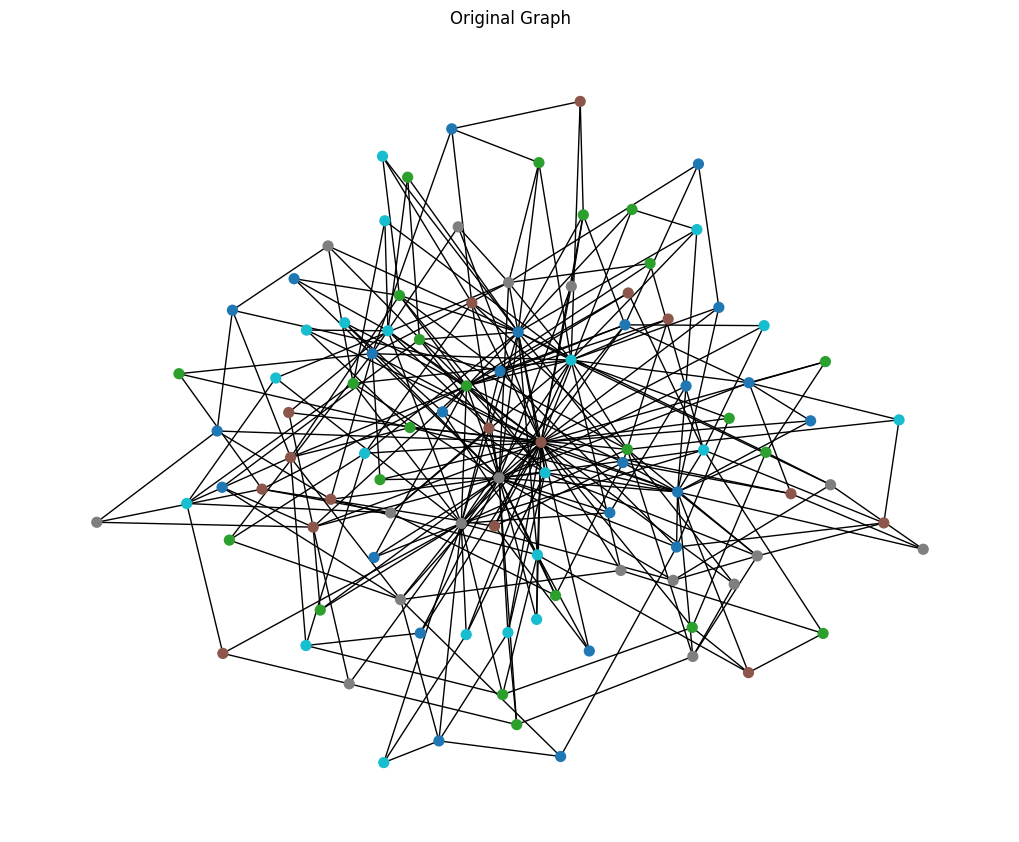

Epoch 000, Loss: 1.6064, Val Acc: 0.1333
Epoch 010, Loss: 0.1685, Val Acc: 0.1333
Epoch 020, Loss: 0.0009, Val Acc: 0.2000
Epoch 030, Loss: 0.0000, Val Acc: 0.2000
Epoch 040, Loss: 0.0000, Val Acc: 0.2000
Epoch 050, Loss: 0.0000, Val Acc: 0.2000
Epoch 060, Loss: 0.0000, Val Acc: 0.2000
Epoch 070, Loss: 0.0000, Val Acc: 0.2000
Epoch 080, Loss: 0.0000, Val Acc: 0.2000
Epoch 090, Loss: 0.0000, Val Acc: 0.2000


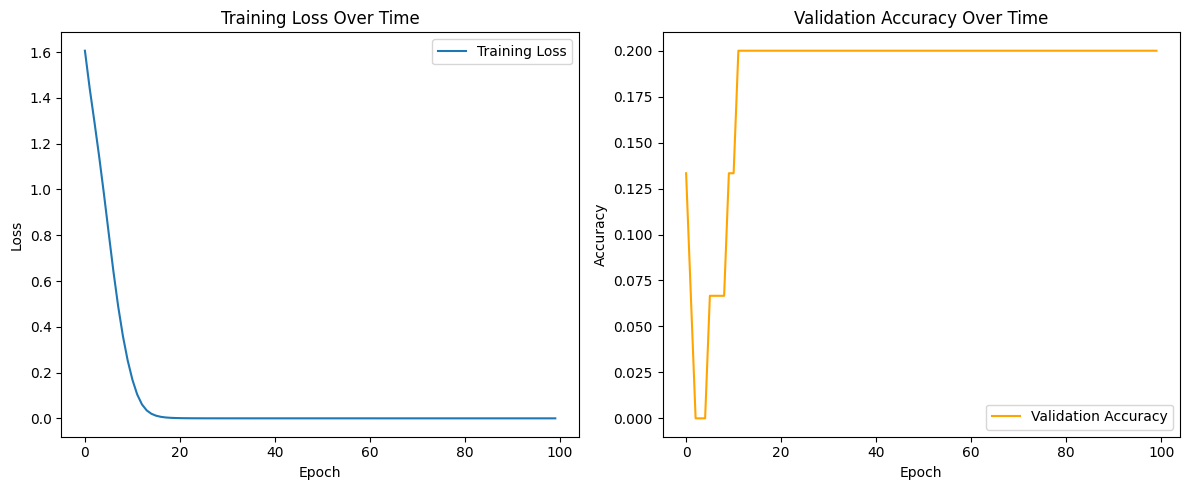

Test Accuracy: 0.3333


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score

class SpectralLayer(nn.Module):
    def __init__(self, in_features, out_features, eigenvecs):
        super(SpectralLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.register_buffer('U', eigenvecs)  # Собственные векторы

        # Диагональная матрица параметров
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        # Преобразование в частотную область: x_hat = U^T x
        x_hat = torch.mm(self.U.t(), x)

        # Применение спектрального фильтра (умножение на диагональную матрицу)
        filtered = torch.mm(x_hat, self.weight)

        # Обратное преобразование: x_out = U filtered
        x_out = torch.mm(self.U, filtered)

        return F.relu(x_out)

class SpectralNetwork(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, eigenvecs):
        super(SpectralNetwork, self).__init__()
        self.layer1 = SpectralLayer(num_features, hidden_dim, eigenvecs)
        self.layer2 = SpectralLayer(hidden_dim, hidden_dim, eigenvecs)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

def compute_laplacian_eigen(G):
    """Вычисляет собственные значения и векторы матрицы Лапласа"""
    A = nx.adjacency_matrix(G).toarray()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    # Нормализация: L_norm = I - D^{-1/2}AD^{-1/2}
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
    L_norm = np.eye(A.shape[0]) - np.dot(np.dot(D_inv_sqrt, A), D_inv_sqrt)

    # Вычисление собственных значений и векторов
    eigvals, eigvecs = eigh(L_norm)
    return torch.FloatTensor(eigvecs)

def visualize_graph(G, labels, title="Graph Structure"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=50, with_labels=False)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                 label="Node Class")
    plt.show()

def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Параметры
    num_nodes = 100
    num_features = 32
    hidden_dim = 64
    num_classes = 5
    epochs = 100
    lr = 0.01

    # Генерация данных
    G = nx.barabasi_albert_graph(num_nodes, 3)
    features = np.random.randn(num_nodes, num_features)
    labels = np.random.randint(0, num_classes, num_nodes)

    # Вычисление собственных векторов матрицы Лапласа
    eigvecs = compute_laplacian_eigen(G)

    # Визуализация исходного графа
   # visualize_graph(G, labels, "Original Graph")

    # Преобразование данных
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    # Разделение данных
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    indices = torch.randperm(num_nodes)
    train_mask[indices[:int(0.7*num_nodes)]] = True
    val_mask[indices[int(0.7*num_nodes):int(0.85*num_nodes)]] = True
    test_mask[indices[int(0.85*num_nodes):]] = True

    # Модель и оптимизатор
    model = SpectralNetwork(num_features, hidden_dim, num_classes, eigvecs)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(features)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            pred = model(features).argmax(dim=1)
            val_acc = accuracy_score(labels[val_mask].numpy(), pred[val_mask].numpy())
            val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(features).argmax(dim=1)
        test_acc = accuracy_score(labels[test_mask].numpy(), pred[test_mask].numpy())
        print(f'Test Accuracy: {test_acc:.4f}')

    # Визуализация предсказаний
   # visualize_graph(G, pred.numpy(), "Predicted Classes")

if __name__ == '__main__':
    main()